# Inference Kernel Demo II
## This notebook is an update of this [work](https://www.kaggle.com/humananalog/inference-demo). 
## If it is useful for you, please consider your upvote.

This is the kernel I’ve used for my recent submissions. It takes about 5-6 hours on the test set, using only CPU. 

I’ve provided this kernel because a lot of people have problems making submissions. This method works and has never errored out for me. (Although I haven't tried making a submission using the GPU yet -- so no guarantees there.)

It uses BlazeFace for face extraction (see also [my BlazeFace kernel](https://www.kaggle.com/humananalog/starter-blazeface-pytorch)) and ResNeXt50 as the classifier model.

We take the average prediction over 17 frames from each video. (Why 17? Using more frames makes the kernel slower, but doesn't appear to improve the score much. I used an odd number so we don't always land on even frames.)

**Please use this kernel only to learn from...** Included is the checkpoint for a ResNeXt50 model that hasn't really been trained very well yet. I'm sure you can improve on it by training your own model!

You could use the included trained weights to get yourself an easy top-50 score on the leaderboard (as of 24 Jan 2020) but it’s nicer to use it as a starting point for your own work. :-)

In [1]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.patches as patches
from tqdm import tqdm

from PIL import Image

torch.cuda.is_available()

True

In [2]:
# TRAIN_PATH = Path('../input/deepfake-detection-challenge/train_sample_videos/') 
# TEST_PATH = Path('../input/deepfake-detection-challenge/test_videos/') 

## Create helpers

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.3.1
CUDA version: 10.0.130
cuDNN version: 7605


In [3]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [4]:
import sys
sys.path.insert(0, "../input/blazeface-pytorch")
sys.path.insert(0, "../input/deepfakes-inference-demo")

In [5]:
from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("../input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("../input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [6]:
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

frames_per_video = 25  
video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [7]:
input_size = 224    # 224 x 224 x 3 

# Save training data

In [9]:
# TEST DISPLAY
faces = face_extractor.process_video(TRAIN_PATH/'aagfhgtpmv.mp4', margin=0.6)
face_extractor.keep_only_best_face(faces)

face = faces[2]['faces'][0]

# resized_face = isotropically_resize_image(face, input_size)
# resized_face = make_square_image(resized_face)

print(face.shape)

plt.imshow(face)

NameError: name 'TRAIN_PATH' is not defined

In [8]:
im = Image.open(open("aagfhgtpmv.mp4_20.jpeg", 'rb'))
plt.imshow(np.array(im))

FileNotFoundError: [Errno 2] No such file or directory: 'aagfhgtpmv.mp4_20.jpeg'

# New Code here (with different chunks)

In [30]:
# TRAIN_PATH = Path('../input/deepfake-detection-challenge/test_videos/') 

SOURCE_PATH=Path('data/dfdc_train_part_24/')
OUTPUT_PATH = Path('data/temp')

In [31]:
train_sample_data = pd.read_json(SOURCE_PATH/'metadata.json').T
train_sample_data

,label,split,original
anijjqtfth.mp4,FAKE,train,qbwwpvgyhh.mp4
zffofixoeh.mp4,FAKE,train,bjdtgkmvza.mp4
rkbynalsjc.mp4,FAKE,train,qbwwpvgyhh.mp4
kyknzgpgvh.mp4,FAKE,train,hyhczxthrs.mp4
lklxnnznwk.mp4,FAKE,train,sxjdqerkfp.mp4
...,...,...,...
fxfxrgntdt.mp4,FAKE,train,ggltfenzwo.mp4
ftmdkroplr.mp4,FAKE,train,dcrkfowrrh.mp4
uvjevytnqy.mp4,REAL,train,NaN
ieybeoxyyd.mp4,FAKE,train,gstyhbnxwx.mp4


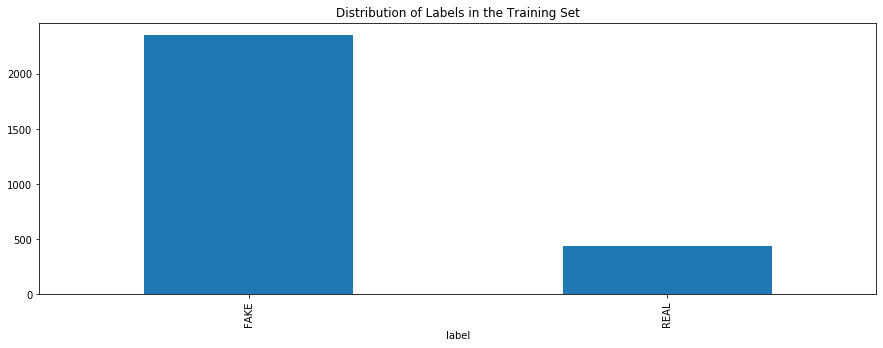

label
FAKE    2347
REAL     439
Name: label, dtype: int64


In [32]:
# Just a bit of statistics to see how many frames to take
train_sample_data.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

print(train_sample_data.groupby('label')['label'].count())

In [33]:
# Create folder train
if not os.path.exists('data/temp/'):
    os.makedirs('data/temp/')

In [12]:
def process_save_file(input_path, file_name, output_path):
    
    if not os.path.exists(input_path/file_name):
        print(f"File {input_path/file_name} does not exist")
        return
    
    faces = face_extractor.process_video(input_path/file_name, margin=0.6)
    face_extractor.keep_only_best_face(faces)

    i = 0
    # TODO: Combine with data to put to different folders :D 
    for frame_face in faces:        
        for face in frame_face["faces"]:    # should only  got 1 here

            im = Image.fromarray(face)
            im.save( f"{output_path/file_name}_{i}.jpeg")
            
            # increase index
            i += 1
        
# process_save_file('aagfhgtpmv.mp4', 'train')

In [34]:
print(SOURCE_PATH)
print(OUTPUT_PATH)

data/dfdc_train_part_24
data/temp


In [35]:
# Save fake files, get 60 frames per fake videos
frames_per_video = 40 

working_directory = OUTPUT_PATH/'fake'
print(working_directory)

# Create folder train
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

fake_files = train_sample_data[train_sample_data['label'] == 'FAKE']
    
for file in tqdm(fake_files.index): 
    process_save_file(SOURCE_PATH, file, working_directory)

  0%|          | 0/2347 [00:00<?, ?it/s]

data/temp/fake


100%|██████████| 2347/2347 [1:05:41<00:00,  1.68s/it]


In [36]:
# Save real files, get 240 frames per real videos
frames_per_video = 240 

working_directory = OUTPUT_PATH/'real'
print(working_directory)

# Create folder train
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

real_files = train_sample_data[train_sample_data['label'] == 'REAL']
    
for file in tqdm(real_files.index): 
    process_save_file(SOURCE_PATH, file, working_directory)

  0%|          | 0/439 [00:00<?, ?it/s]

data/temp/real


100%|██████████| 439/439 [49:23<00:00,  6.75s/it]
